# Anomaly Detection fo Google COVID-19 Community Mobility Data


#Problem Statement
Google COVID-19 Community Mobility Data can be used to build profiles for each entity (in our case - each country) to detect any anomalies in people's behaviors associated with going to the places where they could be exposed to the virus. These anomalies can then be used to possibly predict changes in number of infections for those countries. 

# Data
Google LLC "Google COVID-19 Community Mobility Reports".
https://www.google.com/covid19/mobility/ Accessed: 08/17/2020.

Metadata location: https://www.google.com/covid19/mobility/data_documentation.html?hl=en

In [ ]:
#import libraries we may need
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import Normalizer
import pickle
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [ ]:
!gdown --id 1QVKwkCTksMSJOfU599kuQ4oZG7Dn2f9L --output Global_Mobility_Report.csv


Downloading...
From: https://drive.google.com/uc?id=1QVKwkCTksMSJOfU599kuQ4oZG7Dn2f9L
To: /content/Global_Mobility_Report.csv
128MB [00:00, 214MB/s]


In [ ]:
mobility_df = pd.read_csv('Global_Mobility_Report.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory Data Analysis
Let's take a quick look at few of the data aspects

In [ ]:
mobility_df.describe()

,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,474000.000000,1.156553e+06,1.130873e+06,861526.000000,893573.000000,1.736634e+06,906356.000000
mean,30338.742745,-2.429057e+01,-6.352808e+00,-9.975274,-28.563883,-2.190776e+01,10.205628
std,15297.049711,3.099649e+01,2.442797e+01,63.144284,32.117884,2.141536e+01,9.098440
min,1001.000000,-1.000000e+02,-1.000000e+02,-100.000000,-100.000000,-1.000000e+02,-35.000000
25%,18109.000000,-4.600000e+01,-1.700000e+01,-50.000000,-53.000000,-3.500000e+01,3.000000
50%,29105.000000,-2.000000e+01,-2.000000e+00,-19.000000,-28.000000,-2.200000e+01,9.000000
75%,45057.000000,-1.000000e+00,7.000000e+00,11.000000,-5.000000,-5.000000e+00,16.000000
max,56045.000000,5.450000e+02,4.540000e+02,1206.000000,497.000000,2.580000e+02,57.000000


In [ ]:
mobility_df.dtypes

country_region_code                                    object
country_region                                         object
sub_region_1                                           object
sub_region_2                                           object
metro_area                                             object
iso_3166_2_code                                        object
census_fips_code                                      float64
date                                                   object
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline               float64
residential_percent_change_from_baseline              float64
dtype: object

In [ ]:
mobility_df.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [ ]:
std_by_country_df = mobility_df[(mobility_df['country_region_code'].notnull()) & (mobility_df['sub_region_1'].isnull())].groupby(
    'country_region', as_index=False
    ).agg(
        {
            'retail_and_recreation_percent_change_from_baseline':'std',
            'grocery_and_pharmacy_percent_change_from_baseline':'std', 
            'parks_percent_change_from_baseline':'std', 
            'transit_stations_percent_change_from_baseline':'std', 
            'workplaces_percent_change_from_baseline':'std'
        }
    ).copy()

std_by_country_df

,country_region,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline
0,Afghanistan,21.948794,21.961669,17.371244,20.723608,20.625787
1,Angola,19.033659,15.080225,15.490057,18.990589,19.600989
2,Antigua and Barbuda,21.980052,18.355048,19.038695,25.416266,22.811833
3,Argentina,27.373769,17.407505,29.361098,24.929662,22.307282
4,Aruba,23.914219,19.559915,22.434381,24.439346,21.587909
...,...,...,...,...,...,...
129,Venezuela,22.036831,15.752414,19.801060,21.432994,21.635387
130,Vietnam,16.353107,14.602412,10.289131,18.983327,15.060444
131,Yemen,10.254594,9.227210,8.381450,12.349996,11.254794
132,Zambia,10.326218,9.178875,9.357604,8.360606,13.683839


In [ ]:
top_retail_std_by_country = std_by_country_df[['country_region', 'retail_and_recreation_percent_change_from_baseline']].nlargest(10, ['retail_and_recreation_percent_change_from_baseline'])
top_retail_std_by_country

,country_region,retail_and_recreation_percent_change_from_baseline
67,Liechtenstein,35.921686
82,New Zealand,34.885652
73,Mauritius,34.694070
27,Croatia,34.541141
111,Spain,34.357554
43,Greece,34.206822
102,Réunion,33.976448
38,France,33.357004
55,Italy,33.181475
77,Morocco,32.470626


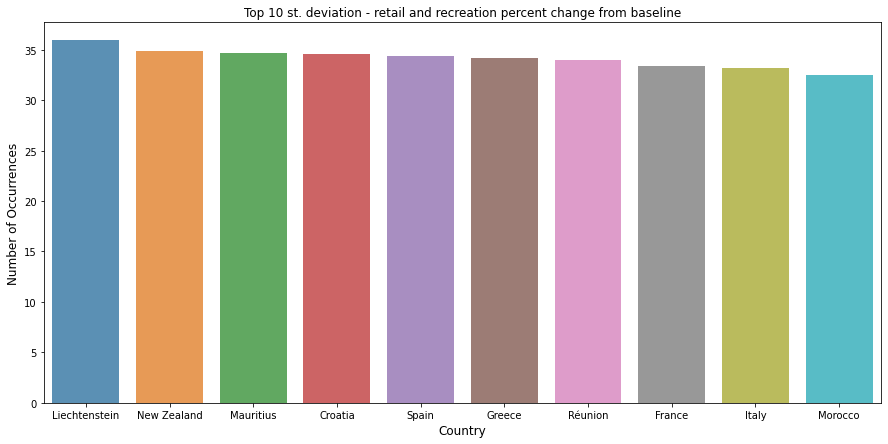

In [ ]:
# Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# in the column 'City'
#city_count  = df['City'].value_counts()
#city_count = city_count[:10,]
plt.figure(figsize=(15,7))
sns.barplot(top_retail_std_by_country['country_region'], top_retail_std_by_country['retail_and_recreation_percent_change_from_baseline'], alpha=0.8)
plt.title('Top 10 st. deviation - retail and recreation percent change from baseline')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

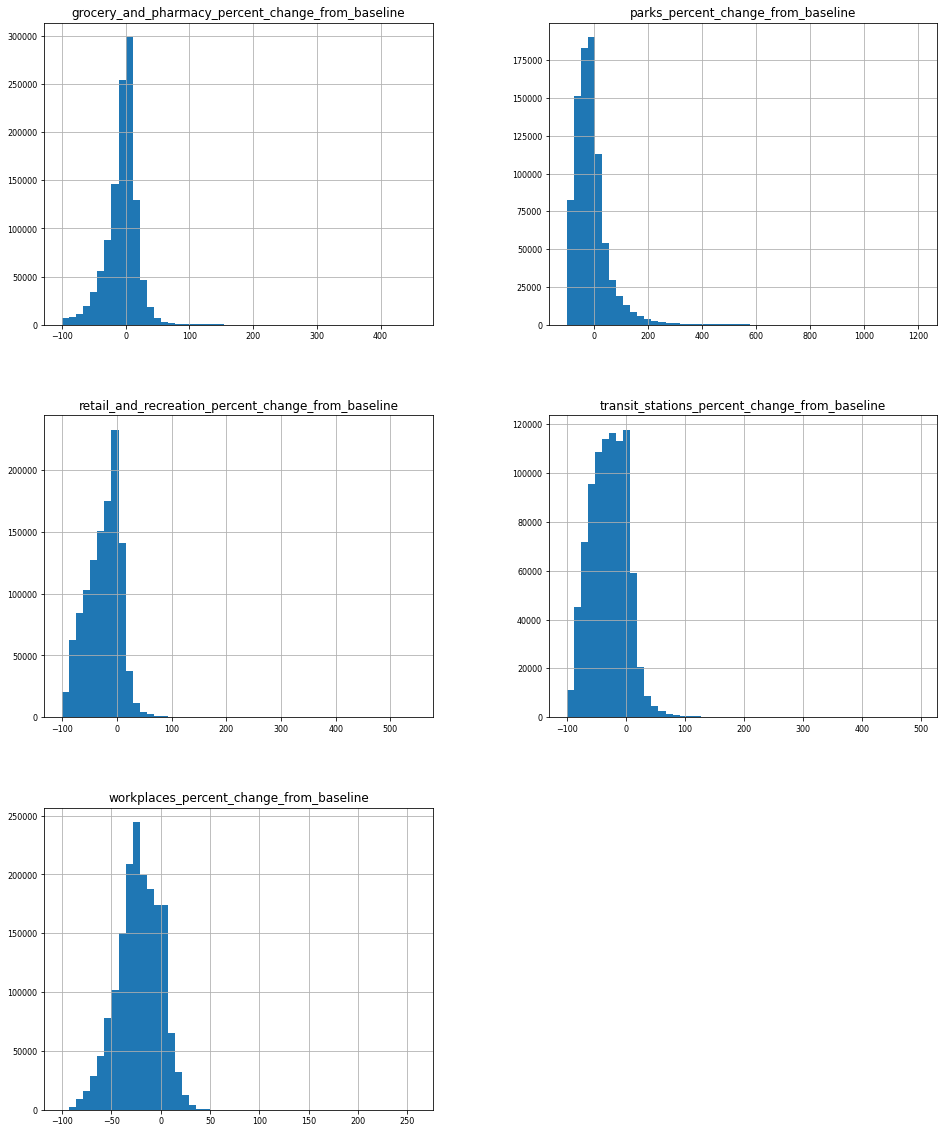

In [ ]:
columns_of_interest = [ 'retail_and_recreation_percent_change_from_baseline',
            'grocery_and_pharmacy_percent_change_from_baseline', 
            'parks_percent_change_from_baseline', 
            'transit_stations_percent_change_from_baseline', 
            'workplaces_percent_change_from_baseline']
mobility_df[columns_of_interest].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

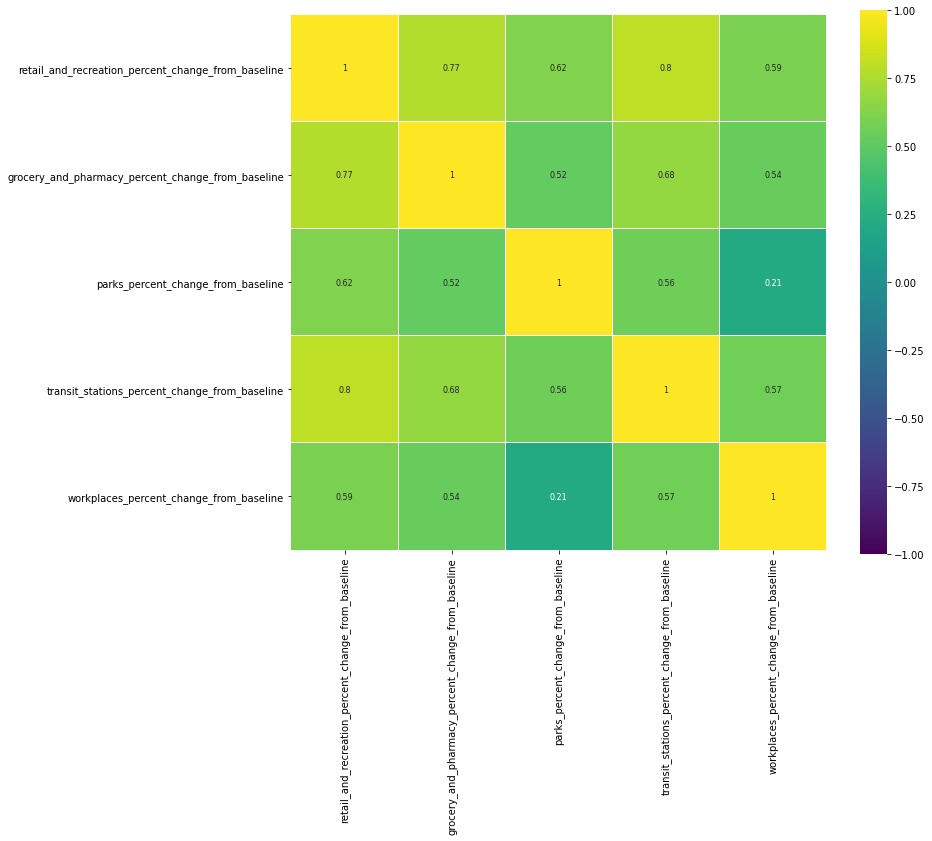

In [ ]:
corr = mobility_df[columns_of_interest].corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#Anomaly Detection
Let's get started with anomaly detection. To start with, we will use Isolation Forest on a single country. As Google recommends, there are vast regional differences in the data, even within one country. We will look into anomalies within one country and then work on building profiles for each country. 

In [ ]:
#pick US to start with
data_df = mobility_df[(mobility_df['country_region_code'] == 'US') & (mobility_df['sub_region_1'].isnull())]

In [ ]:
#for reproducability
state = np.random.RandomState(42)
ifm = IsolationForest(max_samples=len(data_df), n_estimators=100, random_state=state, verbose=1, contamination=0.02)
ifm.fit(data_df[columns_of_interest])
#predictions
y_pred = ifm.predict(data_df[columns_of_interest])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [ ]:
#check which records are considered anomalous
data_df[y_pred == -1]

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1329559,US,United States,NaN,NaN,NaN,NaN,NaN,2020-03-13,2.0,26.0,4.0,-10.0,-7.0,3.0
1329589,US,United States,NaN,NaN,NaN,NaN,NaN,2020-04-12,-63.0,-39.0,-36.0,-56.0,-45.0,13.0
1329632,US,United States,NaN,NaN,NaN,NaN,NaN,2020-05-25,-28.0,-8.0,60.0,-48.0,-72.0,20.0
1329671,US,United States,NaN,NaN,NaN,NaN,NaN,2020-07-03,-10.0,11.0,86.0,-30.0,-57.0,14.0


# Observations: 

The anomaly detection models seems to be on the right track. The four anomalous events can be related to:
3/13 - Donald Trump declares a state of National Emergency under Stafford Act

4/12 (Easter), 5/25 (Memorial Day) and 7/3 (Independence Day observed) were holidays in the US which may have contributed to the behavior change. 

# Building Individual Profiles
Since each country (and even each region within a country) have different behavior profiles, now we will build anomaly detection models for each country. The approach is similar to e.g. building fraud anomaly detection profiles for individual credit card holders. 

In [ ]:
n_estimators=100 
#for reproducability
random_state=np.random.RandomState(42) 
verbose=0
contamination=0.02
columns_of_interest = [ 'retail_and_recreation_percent_change_from_baseline',
            'grocery_and_pharmacy_percent_change_from_baseline', 
            'parks_percent_change_from_baseline', 
            'transit_stations_percent_change_from_baseline', 
            'workplaces_percent_change_from_baseline']

class CountryProfile:
  def __init__(self, country_name):
    self.country_name = country_name
    self.country_data = mobility_df[(mobility_df['country_region'] == self.country_name) & (mobility_df['sub_region_1'].isnull())]

  def train_model(self):
    ifm = IsolationForest(max_samples=len(self.country_data), n_estimators=n_estimators, random_state=random_state, verbose=verbose, contamination=contamination)
    self.ifm = ifm.fit(self.country_data[columns_of_interest])

  def predictions(self):
    self.y_pred = self.ifm.predict(self.country_data[columns_of_interest])

  def anomalies(self):
    self.anomalies = self.country_data[self.y_pred == -1]

In [ ]:
#drop NULL values
mobility_df.dropna(subset=columns_of_interest, how='any', inplace=True)

In [ ]:
#remove any regional data
regional_cols = ['sub_region_1','sub_region_2','metro_area']
mobility_df = mobility_df[mobility_df[regional_cols].isnull().all(axis=1)]

In [ ]:
countries = mobility_df.country_region.unique().tolist()
country_profile_dict = {}
for country in tqdm(countries):
  country_profile = CountryProfile(country)
  country_profile.train_model()
  country_profile.predictions()
  country_profile.anomalies()
  country_profile_dict[country_profile.country_name] = country_profile



100%|██████████| 133/133 [00:35<00:00,  3.70it/s]


In [ ]:
#quick check - should match with above results for United States
country_profile_dict["United States"].anomalies

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1329559,US,United States,NaN,NaN,NaN,NaN,NaN,2020-03-13,2.0,26.0,4.0,-10.0,-7.0,3.0
1329589,US,United States,NaN,NaN,NaN,NaN,NaN,2020-04-12,-63.0,-39.0,-36.0,-56.0,-45.0,13.0
1329632,US,United States,NaN,NaN,NaN,NaN,NaN,2020-05-25,-28.0,-8.0,60.0,-48.0,-72.0,20.0
1329671,US,United States,NaN,NaN,NaN,NaN,NaN,2020-07-03,-10.0,11.0,86.0,-30.0,-57.0,14.0


In [ ]:
#now we can check anomalies for any country, let's see a few...
test_countries = ['Germany', 'India', 'Brazil', 'Ukraine']
for country in test_countries:
  display(country_profile_dict[country].anomalies)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
599917,DE,Germany,NaN,NaN,NaN,NaN,NaN,2020-03-29,-77.0,-51.0,-49.0,-68.0,-39.0,11.0
599932,DE,Germany,NaN,NaN,NaN,NaN,NaN,2020-04-13,-81.0,-93.0,29.0,-73.0,-88.0,28.0
599970,DE,Germany,NaN,NaN,NaN,NaN,NaN,2020-05-21,-55.0,-87.0,225.0,-46.0,-81.0,18.0
599981,DE,Germany,NaN,NaN,NaN,NaN,NaN,2020-06-01,-45.0,-86.0,264.0,-42.0,-80.0,16.0


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
772578,IN,India,NaN,NaN,NaN,NaN,NaN,2020-02-21,-4.0,0.0,6.0,-4.0,-19.0,5.0
772596,IN,India,NaN,NaN,NaN,NaN,NaN,2020-03-10,-19.0,-23.0,-4.0,-22.0,-44.0,11.0
772606,IN,India,NaN,NaN,NaN,NaN,NaN,2020-03-20,-22.0,1.0,-13.0,-18.0,-15.0,7.0
772607,IN,India,NaN,NaN,NaN,NaN,NaN,2020-03-21,-34.0,-4.0,-23.0,-25.0,-18.0,8.0


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
180035,BR,Brazil,NaN,NaN,NaN,NaN,NaN,2020-02-24,-14.0,-7.0,69.0,-27.0,-45.0,8.0
180036,BR,Brazil,NaN,NaN,NaN,NaN,NaN,2020-02-25,-31.0,-29.0,51.0,-35.0,-61.0,10.0
180081,BR,Brazil,NaN,NaN,NaN,NaN,NaN,2020-04-10,-76.0,-38.0,-58.0,-69.0,-72.0,27.0
180092,BR,Brazil,NaN,NaN,NaN,NaN,NaN,2020-04-21,-71.0,-37.0,-51.0,-68.0,-67.0,23.0


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1325865,UA,Ukraine,NaN,NaN,NaN,NaN,NaN,2020-03-07,21.0,21.0,25.0,18.0,6.0,-3.0
1325880,UA,Ukraine,NaN,NaN,NaN,NaN,NaN,2020-03-22,-62.0,-30.0,-44.0,-53.0,-31.0,10.0
1325908,UA,Ukraine,NaN,NaN,NaN,NaN,NaN,2020-04-19,-75.0,-56.0,-17.0,-59.0,-41.0,7.0
1325909,UA,Ukraine,NaN,NaN,NaN,NaN,NaN,2020-04-20,-64.0,-43.0,-8.0,-64.0,-77.0,21.0


# Observations
Since contamination parameter of the Isolation Forest model is fixed at 0.02 for all the countries, the model produces the same number of anomalies for each country.
As suspected, each country has a different behavior profile, resulting in different type of anomalies. 